# Penalized Logistic Regression — Model Training & Hyperparameter Optimization

This notebook trains and tunes **penalized logistic regression models** (Ridge, Lasso, ElasticNet) using the training set.  
All preprocessing is embedded inside a scikit-learn pipeline to avoid data leakage.

**Dataset used:** `train_set.csv`  
**Target:** `NObeyesdad`  
**Task:** Multiclass Classification  
**Metrics:** Accuracy, F1-macro  
**CV Strategy:** StratifiedKFold (5 folds)


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")

# reproducibility
RANDOM_STATE = 42


In [2]:
train = pd.read_csv("../../data/train_set.csv")

train.head()


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.630000,60.000000,Sometimes,yes,3.000000,3.000000,no,yes,2.000000,yes,2.000000,0.000000,Always,Public_Transportation,Normal_Weight
1,20.924956,Female,1.752531,133.618706,Sometimes,yes,3.000000,3.000000,no,no,2.887659,yes,1.480919,0.779641,Sometimes,Public_Transportation,Obesity_Type_III
2,22.899740,Female,1.661715,82.595793,Sometimes,yes,1.203754,1.355354,no,no,2.765593,yes,0.128342,1.659476,Sometimes,Public_Transportation,Obesity_Type_I
3,21.837996,Female,1.588046,44.236067,no,no,3.000000,1.696080,no,no,2.550307,no,1.098862,0.000000,Frequently,Public_Transportation,Insufficient_Weight
4,25.994746,Male,1.811602,106.042142,Sometimes,yes,3.000000,3.000000,no,no,2.858171,yes,1.813318,0.680215,Sometimes,Public_Transportation,Obesity_Type_I


In [3]:
target = "NObeyesdad"

X = train.drop(columns=[target])
y = train[target]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

numeric_features, categorical_features


(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'],
 ['Gender',
  'CALC',
  'FAVC',
  'SCC',
  'SMOKE',
  'family_history_with_overweight',
  'CAEC',
  'MTRANS'])

In [4]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## Logistic Regression Penalties

We tune three types of penalized logistic regression:

- **Ridge (L2 penalty)**: good for correlated predictors  
- **Lasso (L1 penalty)**: performs feature selection  
- **ElasticNet (mixed L1 + L2)**: compromise between Ridge & Lasso

Hyperparameters tuned:
- `C`: inverse regularization strength  
- `l1_ratio`: for ElasticNet only  


In [5]:
logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=5000,
        multi_class="multinomial",
        solver="saga",  # saga supports L1, L2, ElasticNet in multinomial mode
        random_state=RANDOM_STATE
    ))
])


In [6]:
param_grid = [
    # Ridge (L2)
    {
        "clf__penalty": ["l2"],
        "clf__C": [0.01, 0.1, 1, 5, 10]
    },
    # Lasso (L1)
    {
        "clf__penalty": ["l1"],
        "clf__C": [0.01, 0.1, 1, 5, 10]
    },
    # ElasticNet (L1 + L2)
    {
        "clf__penalty": ["elasticnet"],
        "clf__C": [0.01, 0.1, 1, 5, 10],
        "clf__l1_ratio": [0.1, 0.5, 0.9]
    }
]


In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


,estimator,Pipeline(step...ver='saga'))])
,param_grid,"[{'clf__C': [0.01, 0.1, ...], 'clf__penalty': ['l2']}, {'clf__C': [0.01, 0.1, ...], 'clf__penalty': ['l1']}, ...]"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [8]:
best_logreg = grid.best_estimator_
best_params = grid.best_params_

print("Best Parameters:", best_params)

cv_results = pd.DataFrame(grid.cv_results_)[
    ["params", "mean_test_score", "std_test_score"]
].sort_values(by="mean_test_score", ascending=False)

cv_results.head()

Best Parameters: {'clf__C': 5, 'clf__penalty': 'l1'}


,params,mean_test_score,std_test_score
8,"{'clf__C': 5, 'clf__penalty': 'l1'}",0.963756,0.011726
9,"{'clf__C': 10, 'clf__penalty': 'l1'}",0.960232,0.013577
7,"{'clf__C': 1, 'clf__penalty': 'l1'}",0.953442,0.017199
24,"{'clf__C': 10, 'clf__l1_ratio': 0.9, 'clf__pen...",0.949839,0.012199
21,"{'clf__C': 5, 'clf__l1_ratio': 0.9, 'clf__pena...",0.947783,0.012181


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------
# Reproducibility
# --------------------------------------------------------
RANDOM_STATE = 42

# --------------------------------------------------------
# Load Data
# --------------------------------------------------------
df = pd.read_csv("../../data/train_set.csv")

target = "NObeyesdad"
X = df.drop(columns=[target])
y = df[target]

# --------------------------------------------------------
# Internal Train/Test Split (80/20)
# --------------------------------------------------------
X_train, X_test_internal, y_train, y_test_internal = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# --------------------------------------------------------
# Identify Features
# --------------------------------------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

# --------------------------------------------------------
# Preprocessing Pipeline
# --------------------------------------------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# --------------------------------------------------------
# Logistic Regression Pipeline
# --------------------------------------------------------
logreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=5000,
        multi_class="multinomial",
        solver="saga",
        random_state=RANDOM_STATE
    ))
])

# --------------------------------------------------------
# Hyperparameter Grid (Ridge, Lasso, ElasticNet)
# --------------------------------------------------------
param_grid = [
    # Ridge (L2)
    {
        "clf__penalty": ["l2"],
        "clf__C": [0.01, 0.1, 1, 5, 10]
    },
    # Lasso (L1)
    {
        "clf__penalty": ["l1"],
        "clf__C": [0.01, 0.1, 1, 5, 10]
    },
    # ElasticNet
    {
        "clf__penalty": ["elasticnet"],
        "clf__C": [0.01, 0.1, 1, 5, 10],
        "clf__l1_ratio": [0.1, 0.5, 0.9]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

# --------------------------------------------------------
# Fit CV Only on Training Portion
# --------------------------------------------------------
grid.fit(X_train, y_train)

best_logreg = grid.best_estimator_
best_params = grid.best_params_

print("Best Parameters:", best_params)

# --------------------------------------------------------
# Internal Test Evaluation (TA-required)
# --------------------------------------------------------
y_pred_internal = best_logreg.predict(X_test_internal)

internal_acc = accuracy_score(y_test_internal, y_pred_internal)
internal_f1 = f1_score(y_test_internal, y_pred_internal, average="macro")

print("\nInternal Test Accuracy:", internal_acc)
print("Internal Test F1 Score:", internal_f1)

# --------------------------------------------------------
# CV results for reporting
# --------------------------------------------------------
cv_results = pd.DataFrame(grid.cv_results_)[
    ["params", "mean_test_score", "std_test_score"]
].sort_values(by="mean_test_score", ascending=False)

cv_results.head()


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'clf__C': 5, 'clf__penalty': 'l1'}

Internal Test Accuracy: 0.9556213017751479
Internal Test F1 Score: 0.9564889524366975


,params,mean_test_score,std_test_score
8,"{'clf__C': 5, 'clf__penalty': 'l1'}",0.958829,0.012122
9,"{'clf__C': 10, 'clf__penalty': 'l1'}",0.958780,0.010474
24,"{'clf__C': 10, 'clf__l1_ratio': 0.9, 'clf__pen...",0.952510,0.015465
7,"{'clf__C': 1, 'clf__penalty': 'l1'}",0.948250,0.012855
21,"{'clf__C': 5, 'clf__l1_ratio': 0.9, 'clf__pena...",0.945649,0.013725


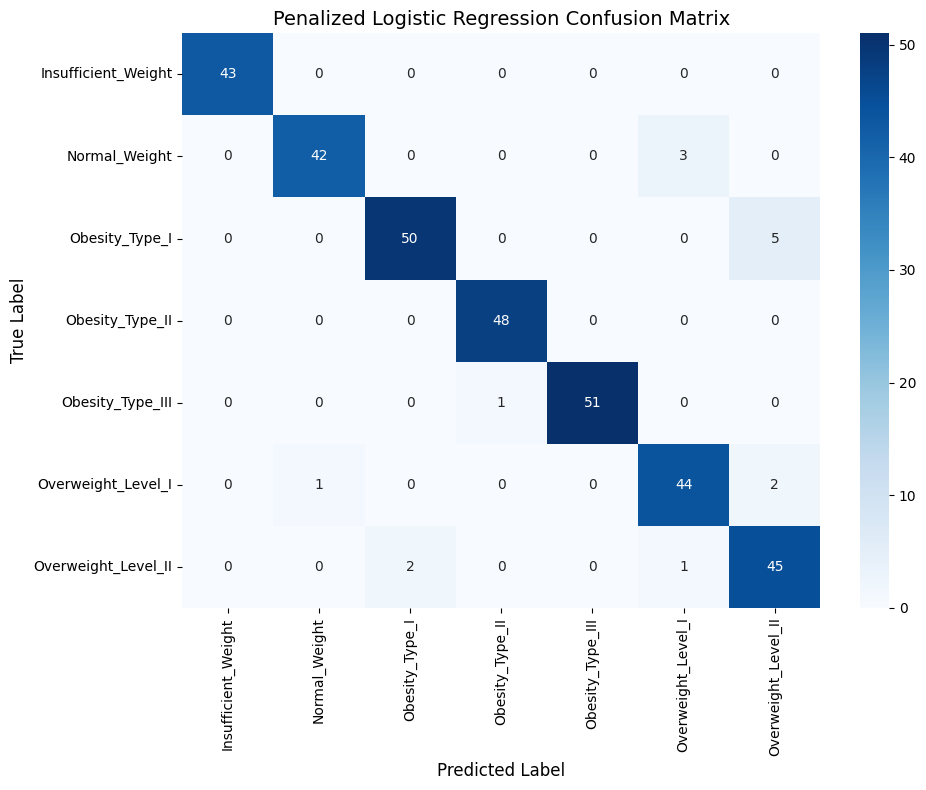

Saved penalized_confusion_matrix.png to OUTPUT folder.


In [24]:


# --------------------------------------------------------
# Generate Confusion Matrix
# --------------------------------------------------------
cm = confusion_matrix(y_test_internal, y_pred_internal)
labels = sorted(y_test_internal.unique())  # ensures consistent order

# --------------------------------------------------------
# Styled Plot (Matches NN Formatting)
# --------------------------------------------------------
plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Penalized Logistic Regression Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# --------------------------------------------------------
# Save to OUTPUT Folder
# --------------------------------------------------------
os.makedirs("../../OUTPUT", exist_ok=True)
plt.savefig("../../OUTPUT/penalized_confusion_matrix.png", dpi=300)

plt.show()
print("Saved penalized_confusion_matrix.png to OUTPUT folder.")
